In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torchvision import models

from src import config, datasource
from src import models as notebook_models

sns.set_theme()
%matplotlib inline

In [2]:
settings = config.get_settings()

In [3]:
df_data = datasource.get_data_frame()
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4976 entries, 0 to 4975
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   class     4976 non-null   object
 1   filename  4976 non-null   object
dtypes: object(2)
memory usage: 77.9+ KB


In [4]:
train, val, test = datasource.get_train_validate_test(df_data=df_data)

train_loader = datasource.get_data_loader(train)
val_loader = datasource.get_data_loader(val)
test_loader = datasource.get_data_loader(test)

In [5]:
class ResNet50Model(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        return self.model(x)

    def apply_sparsity(self, sparsity_rate=0.5):
        """
        Применяет динамическую разреженность.
        sparsity_rate: процент обнулённых весов
        """
        with torch.no_grad():
            weight = self.model.fc.weight.data
            abs_weight = torch.abs(weight)
            threshold = torch.quantile(abs_weight, sparsity_rate)
            weight[abs_weight < threshold] = 0  # Обнуляем веса ниже порога

In [6]:
device = settings.DEVICE
num_classes = 3
model = ResNet50Model(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
py_model = notebook_models.PyTorchModel(model, criterion, optimizer, scheduler, use_abcd_test=False)

c:\Users\User\Desktop\melanoma-classification-deep-learning\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\Desktop\melanoma-classification-deep-learning\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 / 30  - Loss: 488.4594, Train Acc: 0.8553, Val Acc: 0.8259
Epoch 2 / 30  - Loss: 346.9368, Train Acc: 0.8948, Val Acc: 0.846
Epoch 3 / 30  - Loss: 277.4266, Train Acc: 0.9, Val Acc: 0.8728
Epoch 4 / 30  - Loss: 235.1767, Train Acc: 0.9012, Val Acc: 0.8884
Epoch 5 / 30  - Loss: 208.8369, Train Acc: 0.9069, Val Acc: 0.9263
Epoch 6 / 30  - Loss: 186.544, Train Acc: 0.9186, Val Acc: 0.8951
Epoch 7 / 30  - Loss: 167.7965, Train Acc: 0.9228, Val Acc: 0.8906
Epoch 8 / 30  - Loss: 172.4053, Train Acc: 0.9124, Val Acc: 0.8817
Epoch 9 / 30  - Loss: 163.6478, Train Acc: 0.9097, Val Acc: 0.8728
Epoch 10 / 30  - Loss: 147.6495, Train Acc: 0.9243, Val Acc: 0.8862
Epoch 11 / 30  - Loss: 120.1362, Train Acc: 0.9447, Val Acc: 0.9375
Epoch 12 / 30  - Loss: 108.5487, Train Acc: 0.9529, Val Acc: 0.9397
Epoch 13 / 30  - Loss: 103.648, Train Acc: 0.9509, Val Acc: 0.9397
Epoch 14 / 30  - Loss: 100.2972, Train Acc: 0.9543, Val Acc: 0.9397
Epoch 15 / 30  - Loss: 96.1538, Train Acc: 0.9551, Val Acc: 0.9

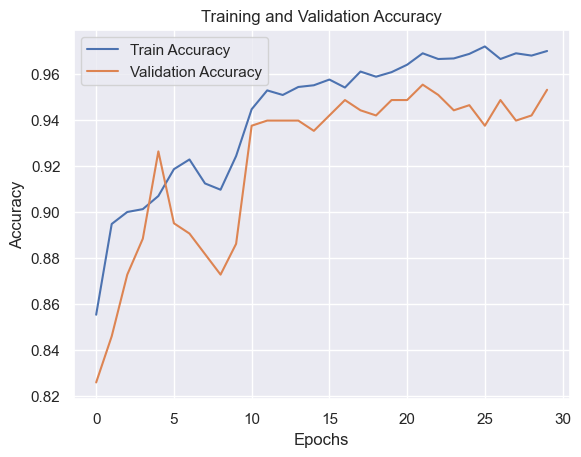

In [7]:
epochs = 30
py_model.fit(train_loader, val_loader, epochs)
py_model.plot_training_and_validation_accuracy()
plt.show()

In [8]:
f1 = py_model.evaluate_on_test_f1(test_loader)
print(f"Test F1 Score: {f1:.4f}")

Test F1 Score: 0.9581


In [9]:
torch.save(py_model.model.state_dict(), "./experiments/weights/resnet18_melanoma_002.pth")
print("✅ Модель сохранена!")

✅ Модель сохранена!
